<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Increase RAM size 
a = []
while(1):
  a.append('1')

In [ ]:
!pip install rastertodataframe
!pip install pyproj
!pip install geopandas

In [1]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling

from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Model metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
from math import floor
from itertools import product
from copy import deepcopy

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# User Defined Functions

In [3]:
#--EVALUATION--
def get_scores(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: The scores and classification report for the model
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Print measure scores
  print(f"Accuracy: {accuracy_score(y, y_prediction)}")
  print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_prediction)}")
  print(f"F1 Score: {f1_score(y, y_prediction, average='micro')}")
  print(f"Precision Score: {precision_score(y, y_prediction, average='micro')}")
  print(f"Recall Score: {recall_score(y, y_prediction, average='micro')}")
  print(f"ROC AUC Score: {roc_auc_score(y, model.predict_proba(x),multi_class='ovr', average='macro')}")

  #print full classification report
  print(classification_report(y, y_prediction))

def create_class_matrix(model, x, y):
  """
  Input: model, x = X_test variable, y = y_test variable
  Output: A confusion matrix plot with all class labels
  """
  #Predict X_test
  y_prediction = model.predict(x)

  #Create a confusion matrix
  matrix = confusion_matrix(y, y_prediction)

  #Visualize the matrix with Seaborn

  #Write title to display accuracy score
  score = balanced_accuracy_score(y, y_prediction)
  all_sample_title = 'RF Accuracy Score: {0}%'.format(round(score,3)*100)

  #Set figure shape
  plt.figure(figsize=(9,9))

  #Use heatmap
  p = sns.heatmap(matrix, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap="mako")

  #Label the plot
  label = [1,2,5,6,8,10,11,12,13,14,15,16,17,18,19]
  p.set_ylabel('Actual Label', size=16)
  p.set_xlabel('Predicted Label', size = 16)
  p.set_xticklabels(label)
  p.set_yticklabels(label)
  p.set_title(all_sample_title, size = 18)

def print_importance(model, x):
    """
    Input: Model and X prior to split]
    Output: Series of feature importance coefficients in descending order
    """
    feature_importances = pd.DataFrame(model.feature_importances_, index = x.columns, columns = ['importance']).sort_values('importance', ascending = False)
    print(feature_importances)

# Download Data

In [4]:
#load raws into dataframe
version10 = pd.read_csv('/content/drive/MyDrive/AISC/version10.csv')
version13 = pd.read_csv('/content/drive/MyDrive/AISC/version13.csv')

#Drop class 0
version10 = version10[version10.y != 0]
version13 = version13[version13.y != 0]

#Subsample 45000
version10 = version10.groupby('y').apply(lambda x: x.sample(n=45000)).reset_index(drop=True)

In [5]:
#Check number of pixels per class in version10
version10.y.value_counts()

1     45000
2     45000
5     45000
6     45000
8     45000
10    45000
11    45000
12    45000
13    45000
14    45000
15    45000
16    45000
17    45000
18    45000
19    45000
Name: y, dtype: int64

In [6]:
#Check number of pixels per class in version13
version13.y.value_counts()

1     80000
2     80000
5     80000
6     80000
8     80000
10    80000
11    80000
12    80000
13    80000
14    80000
15    80000
16    80000
17    80000
18    80000
19    49493
Name: y, dtype: int64

# Train Model - Version10

In [5]:
#split Data
y = version10.y
X = version10.drop('y', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [6]:
#Instantiate and Fit Model
rfc = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6283333333333333
Balanced Accuracy: 0.6283333333333334
F1 Score: 0.6283333333333333
Precision Score: 0.6283333333333333
Recall Score: 0.6283333333333333
ROC AUC Score: 0.9505506884185771
              precision    recall  f1-score   support

           1       0.62      0.61      0.61      9000
           2       0.62      0.63      0.63      9000
           5       0.51      0.48      0.49      9000
           6       0.54      0.62      0.58      9000
           8       0.53      0.51      0.52      9000
          10       0.62      0.54      0.58      9000
          11       0.72      0.79      0.75      9000
          12       0.54      0.46      0.50      9000
          13       0.62      0.67      0.64      9000
          14       0.62      0.64      0.63      9000
          15       0.61      0.69      0.65      9000
          16       0.49      0.28      0.36      9000
          17       0.68      0.78      0.73      9000
          18       0.90      0.88      0.89 

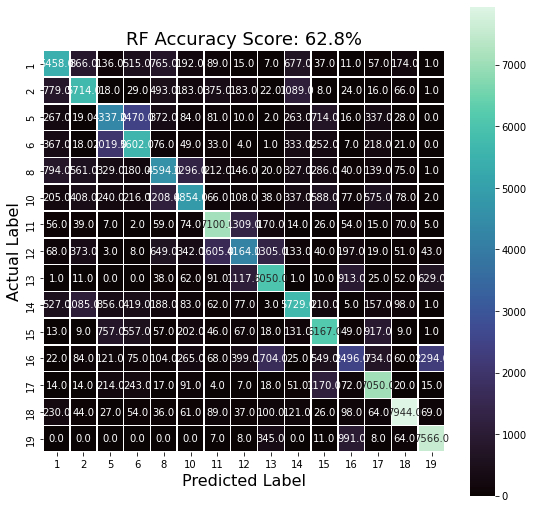

In [12]:
#Get Scores and Matrix
get_scores(rfc, X_test, y_test)

create_class_matrix(rfc, X_test, y_test)

In [10]:
#Find Feature Importance
print_importance(rfc, X)

          importance
NDVI        0.081519
NDSI        0.070372
B02         0.068205
NDWI        0.066469
B12         0.065339
Moisture    0.059297
B04         0.057297
B08         0.056931
B09         0.056300
B01         0.056018
B11         0.055047
B06         0.054599
B01f        0.054381
B8A         0.053372
B05         0.050755
B07         0.050356
B03         0.043742


## Second model with dropped features

In [13]:
#Drop 4 lowest features on importance
version10 = version10.drop(['B03', 'B07', 'B8A', 'B05'], axis = 1)

#print columns
print(version10.columns)

Index(['B01', 'B02', 'B04', 'B06', 'B08', 'B09', 'B11', 'B12', 'y', 'B01f',
       'NDVI', 'Moisture', 'NDWI', 'NDSI'],
      dtype='object')


In [14]:
#Split Data
y = version10.y
X = version10.drop('y', axis = 1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [15]:
#Instantiate and Fit Model
rfc2 = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6238148148148148
Balanced Accuracy: 0.6238148148148147
F1 Score: 0.6238148148148148
Precision Score: 0.6238148148148148
Recall Score: 0.6238148148148148
ROC AUC Score: 0.9493325723691949
              precision    recall  f1-score   support

           1       0.62      0.60      0.61      9000
           2       0.61      0.64      0.62      9000
           5       0.51      0.48      0.49      9000
           6       0.54      0.62      0.58      9000
           8       0.52      0.50      0.51      9000
          10       0.61      0.53      0.57      9000
          11       0.71      0.78      0.74      9000
          12       0.54      0.46      0.49      9000
          13       0.61      0.67      0.64      9000
          14       0.61      0.63      0.62      9000
          15       0.61      0.68      0.64      9000
          16       0.48      0.27      0.35      9000
          17       0.68      0.78      0.72      9000
          18       0.90      0.88      0.89 

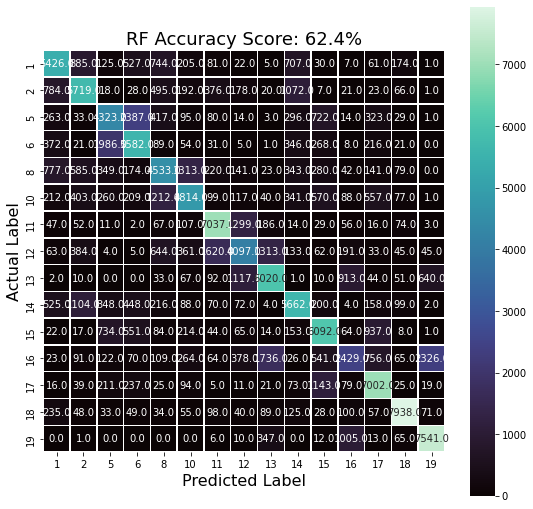

In [16]:
#Get Scores and Matrix
get_scores(rfc2, X_test, y_test)

create_class_matrix(rfc2, X_test, y_test)

In [17]:
#Find Feature Importance
print_importance(rfc2, X)

          importance
NDVI        0.095540
NDWI        0.087168
NDSI        0.085176
B12         0.082609
B09         0.078497
B06         0.077969
B02         0.077179
B04         0.076159
Moisture    0.072973
B11         0.071178
B08         0.067384
B01         0.065235
B01f        0.062933


# Model for Version 13

In [7]:
#Split Data
y = version13.y
X = version13.drop('y', axis = 1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [8]:
#Instantiate and Fit Model
model1 = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6710075716441712
Balanced Accuracy: 0.6739933987439808
F1 Score: 0.6710075716441712
Precision Score: 0.6710075716441712
Recall Score: 0.6710075716441712
ROC AUC Score: 0.9630795572244054
              precision    recall  f1-score   support

           1       0.65      0.59      0.62     16000
           2       0.65      0.65      0.65     16000
           5       0.57      0.52      0.54     16000
           6       0.60      0.66      0.62     16000
           8       0.59      0.60      0.60     16000
          10       0.64      0.66      0.65     16000
          11       0.75      0.84      0.79     16000
          12       0.60      0.49      0.54     16000
          13       0.66      0.72      0.69     16000
          14       0.72      0.74      0.73     16000
          15       0.68      0.76      0.72     16000
          16       0.62      0.43      0.51     16000
          17       0.72      0.77      0.74     16000
          18       0.92      0.88      0.90 

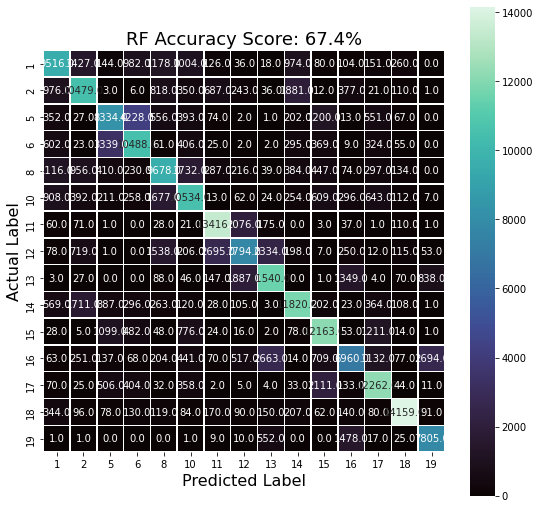

In [9]:
#Get Scores and Matrix
get_scores(model1, X_test, y_test)

create_class_matrix(model1, X_test, y_test)

In [10]:
#Find Feature Importance
print_importance(model1, X)

          importance
NDVI        0.049405
NDWI        0.048616
NDSI        0.046547
B02g        0.046310
B04g        0.042416
B12g        0.040580
B03g        0.039089
B07g        0.038088
B08g        0.037564
B06g        0.037222
B11g        0.036814
B01g        0.036683
B12         0.036416
B02         0.036370
B01         0.034983
B04         0.033384
B8A         0.033382
Moisture    0.032558
B05g        0.031220
B05         0.030925
B09g        0.030715
B8Ag        0.030568
B08         0.030304
B11         0.029991
B09         0.029811
B07         0.027020
B06         0.026283
B03         0.025620
clusters    0.001116


## Drop lowest features

In [7]:
#Drop lowest features on importance
version13 = version13.drop(['clusters', 'B03', 'B06', 'B07', 'B09', 'B11', 'B08', 'B8Ag', 'B09g', 'B05g'], axis = 1)

#print columns
print(version13.columns)

Index(['B01', 'B02', 'B04', 'B05', 'B12', 'B8A', 'y', 'B01g', 'B02g', 'B03g',
       'B04g', 'B06g', 'B07g', 'B08g', 'B11g', 'B12g', 'NDVI', 'Moisture',
       'NDWI', 'NDSI'],
      dtype='object')


In [8]:
#Split Data
y = version13.y
X = version13.drop('y', axis = 1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

In [9]:
#Instantiate and Fit Model
model2 = RandomForestClassifier(random_state=123).fit(X_train, y_train)

Accuracy: 0.6702294580139291
Balanced Accuracy: 0.6733095380004716
F1 Score: 0.6702294580139291
Precision Score: 0.6702294580139291
Recall Score: 0.6702294580139291
ROC AUC Score: 0.962827616408634
              precision    recall  f1-score   support

           1       0.65      0.59      0.62     16000
           2       0.65      0.66      0.65     16000
           5       0.57      0.52      0.54     16000
           6       0.60      0.65      0.62     16000
           8       0.60      0.60      0.60     16000
          10       0.64      0.66      0.65     16000
          11       0.75      0.84      0.79     16000
          12       0.59      0.48      0.53     16000
          13       0.66      0.72      0.69     16000
          14       0.72      0.74      0.73     16000
          15       0.68      0.76      0.72     16000
          16       0.62      0.43      0.51     16000
          17       0.72      0.76      0.74     16000
          18       0.92      0.88      0.90  

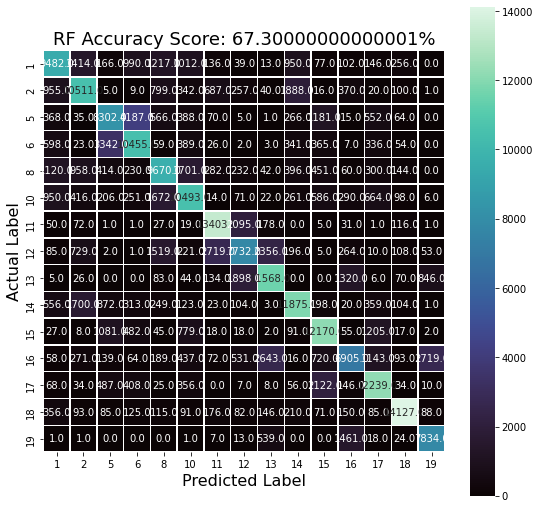

In [10]:
#Get Scores and Matrix
get_scores(model2, X_test, y_test)

create_class_matrix(model2, X_test, y_test)

In [11]:
#Find Feature Importance
print_importance(model2, X)

          importance
NDWI        0.065658
NDVI        0.064564
B08g        0.063295
NDSI        0.057237
B02g        0.057058
B04g        0.056422
B06g        0.054621
B07g        0.053231
B12         0.052086
B04         0.050634
B12g        0.050167
B8A         0.050002
B03g        0.048672
B11g        0.047939
B05         0.047322
B01g        0.046986
B02         0.046194
Moisture    0.044614
B01         0.043299


# Grid Search

In [ ]:
#Define grid search params
param_grid = [{'n_estimators': [100,200,300,400],
                'min_samples_leaf': [1,2,3,4],
                'max_depth': [5,6,7,8,9],
                'min_samples_split':[2,3,4]}]

#Run grid search
rfc_gs = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring = 'accuracy', cv = 5)

#Fit training data
rfc_gs.fit(X_train, y_train)